# PhishEye

### Import Statements

In [2]:
import pandas as pd
import dnstwist
import numpy as np 
import matplotlib.pyplot as plt 


### Dataset Exploration

In [188]:
fuzz = dnstwist.Fuzzer("www.google.com")
fuzz.generate()
len(fuzz.permutations())

2158

In [189]:
data = dnstwist.run(domain='google.com', registered=True, format='null')
reg = [d['domain'] for d in data]


In [190]:
data_non = dnstwist.run(domain='google.com', unregistered=True, format='null')
nonreg = [d['domain'] for d in data_non]


In [ ]:
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

intersection(reg, nonreg)

In [ ]:
print (f'The number of registered permutations is: {len(reg)}')
print (f'The number of non registered permutations is: {len(nonreg)}')


In [ ]:
print (reg[::15])
print (nonreg[::150])

In [ ]:
domains_df = pd.read_csv('./top-1m.csv', header=None, index_col=0)
domains_df.head()

In [ ]:
def get_dicts(domain_list):
    reg_dict, nonreg_dict = {}, {}
    for domain in domain_list:
        data_reg = dnstwist.run(domain=f'{domain}', registered=True, format='null')
        reg = [d['domain'] for d in data_reg]
        reg_dict[domain]  = len(reg)
        data_nonreg = dnstwist.run(domain=f'{domain}', unregistered=True, format='null')
        nonreg = [d['domain'] for d in data_nonreg]
        nonreg_dict[domain]  = len(nonreg)
    return reg_dict, nonreg_dict
# eda_reg, eda_nonreg = get_dicts(list(domains_df[1].values[:10]))
# eda_reg


In [ ]:
# x = list(eda_reg.keys())
# Yreg = list(eda_reg.values())
# Znonreg= list(eda_nonreg.values())
# X_axis = np.arange(len(x))
  
# plt.bar(x, Znonreg, color='steelblue')
# plt.bar(x, Yreg, bottom=Znonreg, color='darkorange')
  
# plt.xlabel("Domains")
# plt.ylabel("Number of Permutations")
# plt.title("Number of Registered and Non Registered Domain Permutations")
# plt.xticks(rotation=30)

# plt.legend(labels = ['Non Registered: Benign', 'Registered: Malicious'])
# plt.show()

In [ ]:
def create_twist_dict(domains):
    twist_dict = {}
    for domain in domains:
        #twist_dict[domain] = [[],[]]
        data_reg = dnstwist.run(domain=f'{domain}', registered=True, format='null')
        reg = [d['domain'] for d in data_reg]
        for homograph in reg:
            twist_dict[homograph] = [domain, True]

        data_nonreg = dnstwist.run(domain=f'{domain}', unregistered=True, format='null')
        nonreg = [d['domain'] for d in data_nonreg]
        for homograph in nonreg:
            twist_dict[homograph] = [domain, False]
    return twist_dict

twisted_dict = create_twist_dict(list(domains_df[1].values[:10]))

In [ ]:
twisted_df = pd.DataFrame.from_dict(twisted_dict, orient='index').reset_index()
twisted_df.columns = ['Homograph', 'Domain', 'Registered']
twisted_df.to_csv('twisted.csv')
twisted_df


### Text Distance Metrics

In [133]:
from strsimpy.levenshtein import Levenshtein
from strsimpy.jaro_winkler import JaroWinkler
from strsimpy.sorensen_dice import SorensenDice
from strsimpy.cosine import Cosine

test_string1 = reg[0] # google.com
test_string2 = nonreg[1] # g00qle.com

levenshtein = Levenshtein()
print(levenshtein.distance(test_string1, test_string2))

jarowinkler = JaroWinkler()
print(jarowinkler.distance(test_string1, test_string2))

sorensondice = SorensenDice()
print(sorensondice.distance(test_string1, test_string2))

cosine = Cosine(2)
a = cosine.get_profile(test_string1)
b = cosine.get_profile(test_string2)
print(cosine.similarity_profiles(a,b))


NameError: name 'reg' is not defined

In [ ]:
for index, row in twisted_df.iterrows():
    twisted_df.loc[index,'Levenshtein'] = levenshtein.distance(row['Domain'], row['Homograph'])
    twisted_df.loc[index,'Jaro-Winkler'] = jarowinkler.distance(row['Domain'], row['Homograph'])
    twisted_df.loc[index,'Sorenson-Dice'] = sorensondice.distance(row['Domain'], row['Homograph'])
    str_to_vect_a= cosine.get_profile(row['Domain'])
    str_to_vect_b= cosine.get_profile(row['Homograph'])
    twisted_df.loc[index,'Cosine'] = cosine.similarity_profiles(str_to_vect_a, str_to_vect_b)

twisted_df    

In [103]:
# twisted_df.to_csv('twisted_text_distance.csv')
twisted_df = pd.read_csv('twisted_text_distance.csv')

### Image Similarity

In [8]:
from PIL import Image, ImageDraw, ImageFont

In [ ]:
# test sizing
lengths = [len(s) for s in twisted_df.Homograph]
longest_idx= lengths.index(max(lengths))
text = twisted_df.Homograph[longest_idx]
img = Image.new('RGB', (1024, 128))
# use bold font
font = ImageFont.truetype(f"./fonts/arial bold.ttf",70)
# draw image
d1 = ImageDraw.Draw(img)
# Center text in image
xpos = (img.size[0] / 2) - (font.getsize(text)[0]/2)
ypos = (img.size[1] / 2) - (font.getsize(text)[1]/2)
d1.text((xpos, ypos), text, fill =(255, 255, 255), font=font)
# show image
img.show()


In [6]:
import os.path

def create_image(string, font='arial.ttf', show=False):
    if not os.path.isfile(f'./images/{string}.jpeg'):
        img = Image.new('RGB', (1024, 128))
        text = string
        # use declared font
        font = ImageFont.truetype(f"./fonts/{font}",70)
        # draw image
        d1 = ImageDraw.Draw(img)
        # Center text in image
        xpos = (img.size[0] / 2) - (font.getsize(text)[0]/2)
        ypos = (img.size[1] / 2) - (font.getsize(text)[1]/2)
        d1.text((xpos, ypos), text, fill =(255, 255, 255), font=font)
        # show and save the image
        if show:
            img.show()
        img.save(f'images/{string}.jpeg')

# for test_string in [test_string1, test_string2]:
#     create_image(test_string, show=True)


### Simple

In [104]:
from skimage.metrics import structural_similarity as ssim, mean_squared_error as mse
import numpy as np
import cv2

def calculate_similarity(string_a, string_b):
    imageA = cv2.imread(f'./images/{string_a}.jpeg')
    imageB= cv2.imread(f'./images/{string_b}.jpeg')
    gsA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
    gsB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)
    # Calculate the MSE, SSIM, COR
    m = mse(gsA, gsB)
    s = ssim(gsA, gsB)
    return  m, s
# calculate_similarity(test_string1, test_string2)

In [105]:
for index, row in twisted_df.iterrows():
    create_image(row['Domain'])
    create_image(row['Homograph'])
    m, s = calculate_similarity(row['Domain'], row['Homograph'])
    twisted_df.loc[index,'IMG_MSE'] = m
    twisted_df.loc[index,'IMG_SSM'] = s
twisted_df


KeyboardInterrupt: 

In [12]:
twisted_df = pd.read_csv('twisted_viz_sim.csv', index_col=0)
twisted_df

,Homograph,Domain,Registered,Levenshtein,Jaro-Winkler,Sorenson-Dice,Cosine,MSE,SSM
0,google.com,google.com,True,0.0,0.000000,0.000000,1.000000,0.000000,1.000000
1,google7.com,google.com,True,1.0,0.013774,0.294118,0.843274,3573.467743,0.848874
2,googlea.com,google.com,True,1.0,0.013774,0.294118,0.843274,3562.883354,0.851078
3,googled.com,google.com,True,1.0,0.013774,0.294118,0.843274,3576.705872,0.849858
4,googlej.com,google.com,True,1.0,0.013774,0.294118,0.843274,3890.821388,0.849594
...,...,...,...,...,...,...,...,...,...
47009,i.nstagram.com,instagram.com,False,1.0,0.022109,0.130435,0.880705,4724.995277,0.821886
47010,in.stagram.com,instagram.com,False,1.0,0.020408,0.217391,0.880705,4730.435272,0.820904
47011,inst.agram.com,instagram.com,False,1.0,0.071952,0.217391,0.880705,4727.817451,0.821145
47012,insta.gram.com,instagram.com,False,1.0,0.048273,0.217391,0.880705,4748.178596,0.821017


### Deep Learning

In [11]:
import torch
from torchvision import models, transforms

def siamese_similarity(string_a, string_b):
    # preprocess images
    imgA = Image.open(f'./images/{string_a}.jpeg').convert('RGB')
    imgB = Image.open(f'./images/{string_b}.jpeg').convert('RGB')

    transform = transforms.ToTensor()
    imgA = transform(imgA).unsqueeze(0)
    imgB = transform(imgB).unsqueeze(0)

    net = models.resnet50(weights='ResNet50_Weights.DEFAULT')
    embedding_size = net.fc.in_features
    net.fc = torch.nn.Linear(embedding_size, 256)

    embedding1 = net(imgA).detach()
    embedding2 = net(imgB).detach()
    e = torch.nn.functional.pairwise_distance(embedding1, embedding2).item()
    c = torch.nn.functional.cosine_similarity(embedding1, embedding2).item()
    l = torch.nn.functional.l1_loss(embedding1, embedding2).item()
    return e, c, l



In [13]:
for index, row in twisted_df.iterrows():
    create_image(row['Domain'])
    create_image(row['Homograph'])
    e, c, l = siamese_similarity(row['Domain'], row['Homograph'])
    twisted_df.loc[index,'EMBD_EUC'] = e
    twisted_df.loc[index,'EMBD_COS'] = c
    twisted_df.loc[index,'EMBD_L1'] = l

twisted_df

,Homograph,Domain,Registered,Levenshtein,Jaro-Winkler,Sorenson-Dice,Cosine,MSE,SSM,EMBD_EUC,EMBD_COS,EMBD_L1
0,google.com,google.com,True,0.0,0.000000,0.000000,1.000000,0.000000,1.000000,0.000016,1.000000,0.000000
1,google7.com,google.com,True,1.0,0.013774,0.294118,0.843274,3573.467743,0.848874,0.464163,0.801736,0.023069
2,googlea.com,google.com,True,1.0,0.013774,0.294118,0.843274,3562.883354,0.851078,0.456447,0.780336,0.022861
3,googled.com,google.com,True,1.0,0.013774,0.294118,0.843274,3576.705872,0.849858,0.523681,0.818360,0.026033
4,googlej.com,google.com,True,1.0,0.013774,0.294118,0.843274,3890.821388,0.849594,0.409549,0.863152,0.020503
...,...,...,...,...,...,...,...,...,...,...,...,...
47009,i.nstagram.com,instagram.com,False,1.0,0.022109,0.130435,0.880705,4724.995277,0.821886,0.568484,0.827922,0.029100
47010,in.stagram.com,instagram.com,False,1.0,0.020408,0.217391,0.880705,4730.435272,0.820904,0.730263,0.771949,0.035950
47011,inst.agram.com,instagram.com,False,1.0,0.071952,0.217391,0.880705,4727.817451,0.821145,0.609621,0.828346,0.030572
47012,insta.gram.com,instagram.com,False,1.0,0.048273,0.217391,0.880705,4748.178596,0.821017,0.690725,0.784406,0.034384


In [93]:
twisted_df.to_csv('twisted_viz_sim_siamese.csv')

In [10]:
twisted_df = pd.read_csv('twisted_viz_sim_siamese.csv', index_col=0)
twisted_df['Registered'].value_counts()[False]


45105

In [11]:
twisted_df.set_index(twisted_df.apply(lambda row: (row['Homograph'], row['Domain']), axis=1), inplace=True)
twisted_df.to_csv('twisted_viz_sim_siamese_lev.csv')


In [12]:
twisted_df

,Homograph,Domain,Registered,Levenshtein,Jaro-Winkler,Sorenson-Dice,Cosine,MSE,SSM,EMBD_EUC,EMBD_COS,EMBD_L1
"(google.com, google.com)",google.com,google.com,True,0.0,0.000000,0.000000,1.000000,0.000000,1.000000,0.000016,1.000000,0.000000
"(google7.com, google.com)",google7.com,google.com,True,1.0,0.013774,0.294118,0.843274,3573.467743,0.848874,0.464163,0.801736,0.023069
"(googlea.com, google.com)",googlea.com,google.com,True,1.0,0.013774,0.294118,0.843274,3562.883354,0.851078,0.456447,0.780336,0.022861
"(googled.com, google.com)",googled.com,google.com,True,1.0,0.013774,0.294118,0.843274,3576.705872,0.849858,0.523681,0.818360,0.026033
"(googlej.com, google.com)",googlej.com,google.com,True,1.0,0.013774,0.294118,0.843274,3890.821388,0.849594,0.409549,0.863152,0.020503
...,...,...,...,...,...,...,...,...,...,...,...,...
"(i.nstagram.com, instagram.com)",i.nstagram.com,instagram.com,False,1.0,0.022109,0.130435,0.880705,4724.995277,0.821886,0.568484,0.827922,0.029100
"(in.stagram.com, instagram.com)",in.stagram.com,instagram.com,False,1.0,0.020408,0.217391,0.880705,4730.435272,0.820904,0.730263,0.771949,0.035950
"(inst.agram.com, instagram.com)",inst.agram.com,instagram.com,False,1.0,0.071952,0.217391,0.880705,4727.817451,0.821145,0.609621,0.828346,0.030572
"(insta.gram.com, instagram.com)",insta.gram.com,instagram.com,False,1.0,0.048273,0.217391,0.880705,4748.178596,0.821017,0.690725,0.784406,0.034384


### Single Value Classifiers

In [26]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, plot_roc_curve, plot_precision_recall_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import export_text, DecisionTreeClassifier

import numpy as np

In [27]:
# Functions for running and validating supervised classification models
def model_eval(df, target, model):

    kf = StratifiedKFold(n_splits=5, shuffle=True)

    # Arrays to store metrics
    recall = []
    precision = []
    f1 = []
    auc = []

    for train_index, test_index in kf.split(df, target):
        X_train, X_test = df.iloc[train_index], df.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        recall += [recall_score(y_pred, y_test, zero_division=0)]
        precision += [precision_score(y_pred, y_test)]
        f1 += [f1_score(y_pred, y_test)]
        try:
            auc += [roc_auc_score(y_pred, y_test)]
    
        except: 
            ValueError
    print("precision = {:.4f} ±{:.4f}".format(np.mean(precision), np.std(precision)))
    print("recall    = {:.4f} ±{:.4f}".format(np.mean(recall), np.std(recall)))
    print("f1        = {:.4f} ±{:.4f}".format(np.mean(f1), np.std(f1)))
    print("auc        = {:.4f} ±{:.4f}".format(np.mean(auc), np.std(auc)))

    return  X_test, y_test, model.predict_proba(X_test)

In [22]:
# Add comment
dt_model = DecisionTreeClassifier(max_depth=1)
features = twisted_df.drop(['Domain', 'Homograph', 'Registered'], axis=1)
for col in features.columns:
    print (col)
    model_eval(twisted_df[[col]], twisted_df['Registered'] , dt_model)
    print()
    print(export_text(dt_model, feature_names=[col], decimals=10))


Levenshtein
precision = 0.8088 ±0.0251
recall    = 0.6692 ±0.0167
f1        = 0.7319 ±0.0059
auc        = 0.8305 ±0.0079

|--- Levenshtein <= 2.5000000000
|   |--- class: True
|--- Levenshtein >  2.5000000000
|   |--- class: False

Jaro-Winkler
precision = 0.8261 ±0.0248
recall    = 0.6421 ±0.0113
f1        = 0.7225 ±0.0145
auc        = 0.8173 ±0.0060

|--- Jaro-Winkler <= 0.1100206599
|   |--- class: True
|--- Jaro-Winkler >  0.1100206599
|   |--- class: False

Sorenson-Dice
precision = 0.8109 ±0.0203
recall    = 0.6463 ±0.0177
f1        = 0.7189 ±0.0092
auc        = 0.8191 ±0.0086

|--- Sorenson-Dice <= 0.3798076957
|   |--- class: True
|--- Sorenson-Dice >  0.3798076957
|   |--- class: False

Cosine
precision = 0.8292 ±0.0145
recall    = 0.6627 ±0.0138
f1        = 0.7365 ±0.0099
auc        = 0.8277 ±0.0069

|--- Cosine <= 0.7492276132
|   |--- class: False
|--- Cosine >  0.7492276132
|   |--- class: True

MSE
precision = 0.6433 ±0.0246
recall    = 0.5131 ±0.0128
f1        = 0.5708 ±

In [24]:
dt_model = DecisionTreeClassifier(max_depth=1)
features = twisted_df.drop(['Domain', 'Homograph', 'Registered'], axis=1)
for col in features.columns:
    print (col)
    model_eval(twisted_df[[col]], twisted_df['Registered'] , dt_model)

Levenshtein
precision = 0.8004 ±0.0423
recall    = 0.6804 ±0.0155
f1        = 0.7349 ±0.0193
auc        = 0.8360 ±0.0078
Jaro-Winkler
precision = 0.8261 ±0.0215
recall    = 0.6423 ±0.0183
f1        = 0.7226 ±0.0185
auc        = 0.8174 ±0.0095
Sorenson-Dice
precision = 0.8141 ±0.0243
recall    = 0.6434 ±0.0105
f1        = 0.7185 ±0.0105
auc        = 0.8177 ±0.0052
Cosine
precision = 0.8292 ±0.0150
recall    = 0.6628 ±0.0129
f1        = 0.7365 ±0.0039
auc        = 0.8277 ±0.0062
MSE
precision = 0.6417 ±0.0210
recall    = 0.5154 ±0.0168
f1        = 0.5715 ±0.0167
auc        = 0.7500 ±0.0087
SSM
precision = 0.7166 ±0.0260
recall    = 0.5838 ±0.0199
f1        = 0.6430 ±0.0153
auc        = 0.7859 ±0.0099
EMBD_EUC
precision = 0.4149 ±0.0414
recall    = 0.6428 ±0.0391
f1        = 0.5034 ±0.0370
auc        = 0.8092 ±0.0200
EMBD_COS
precision = 0.2890 ±0.2360
recall    = 0.3015 ±0.2465
f1        = 0.2950 ±0.2410
auc        = 0.7403 ±0.0087
EMBD_L1
precision = 0.4285 ±0.0324
recall    = 0.5890 ±0

### Multi Value Clasifiers

In [19]:
features = features[['MSE', 'SSM','EMBD_EUC']]
features

,MSE,SSM,EMBD_EUC
"(google.com, google.com)",0.000000,1.000000,0.000016
"(google7.com, google.com)",3573.467743,0.848874,0.464163
"(googlea.com, google.com)",3562.883354,0.851078,0.456447
"(googled.com, google.com)",3576.705872,0.849858,0.523681
"(googlej.com, google.com)",3890.821388,0.849594,0.409549
...,...,...,...
"(i.nstagram.com, instagram.com)",4724.995277,0.821886,0.568484
"(in.stagram.com, instagram.com)",4730.435272,0.820904,0.730263
"(inst.agram.com, instagram.com)",4727.817451,0.821145,0.609621
"(insta.gram.com, instagram.com)",4748.178596,0.821017,0.690725


In [38]:
from sklearn.model_selection import GridSearchCV, train_test_split

def grid_search(df, target, model, param_grid):
    X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.2)
    grid_search = GridSearchCV(model, param_grid, scoring='f1')
    grid_search.fit(X_train, y_train)
    return grid_search.best_params_

In [39]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10],
    'criterion': ['gini', 'entropy']
}
rf_model = RandomForestClassifier()
grid_search(features[['MSE', 'SSM','EMBD_EUC']], twisted_df['Registered'] , rf_model, param_grid)

{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 100}

In [41]:
rf_model = RandomForestClassifier(criterion='gini', max_depth=10, n_estimators=100)
features = twisted_df.drop(['Domain', 'Homograph', 'Registered'], axis=1)
model_eval(features[['MSE', 'SSM','EMBD_EUC']], twisted_df['Registered'] , rf_model);   

precision = 0.6422 ±0.0211
recall    = 0.7426 ±0.0183
f1        = 0.6885 ±0.0141
auc        = 0.8638 ±0.0092


In [43]:
from sklearn.neural_network import MLPClassifier
param_grid = {
    'hidden_layer_sizes': [(10,), (50,), (100,)],
    'activation': ['relu', 'tanh'],
    'solver': ['sgd', 'adam'],
}
mlp_model = MLPClassifier()
grid_search(features[['MSE', 'SSM','EMBD_EUC']], twisted_df['Registered'] , mlp_model, param_grid)

{'activation': 'relu', 'hidden_layer_sizes': (100,), 'solver': 'adam'}

In [45]:
mlp_model = MLPClassifier(activation='relu', hidden_layer_sizes=(100,), solver='adam')
features = twisted_df.drop(['Domain', 'Homograph', 'Registered'], axis=1)
model_eval(features[['EMBD_EUC','EMBD_L1', 'EMBD_COS']], twisted_df['Registered'] , mlp_model);

In [ ]:
from sklearn.svm import SVC
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
svm_model = SVC()
grid_search(features[['MSE', 'SSM','EMBD_EUC']], twisted_df['Registered'] , svm_model, param_grid)

precision = 0.1357 ±0.0167
recall    = 0.7337 ±0.0680
f1        = 0.2289 ±0.0266
auc        = 0.8492 ±0.0343


AttributeError: predict_proba is not available when  probability=False

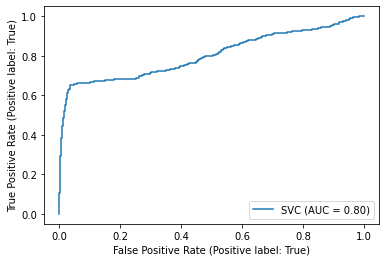

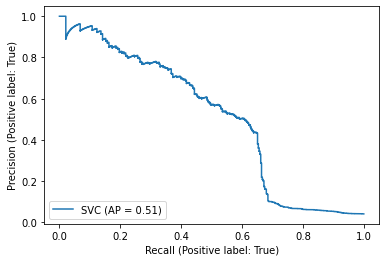

In [165]:
from sklearn.svm import SVC
svm_model = SVC()
features = twisted_df.drop(['Domain', 'Homograph', 'Registered'], axis=1)
model_eval(features[['EMBD_EUC','EMBD_L1', 'EMBD_COS']], twisted_df['Registered'] , svm_model);

In [ ]:
from sklearn.linear_model import LogisticRegression


precision = 0.2242 ±0.0220
recall    = 0.7098 ±0.0359
f1        = 0.3403 ±0.0278
auc        = 0.8389 ±0.0182


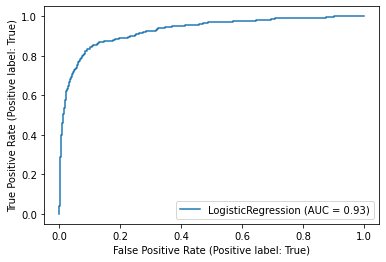

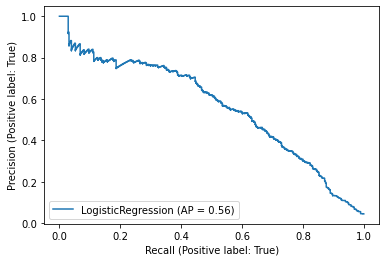

In [166]:
lr_model = LogisticRegression()
features = twisted_df.drop(['Domain', 'Homograph', 'Registered'], axis=1)
model_eval(features[['EMBD_EUC','EMBD_L1', 'EMBD_COS']], twisted_df['Registered'] , lr_model, True);

precision = 0.6370 ±0.0186
recall    = 0.7091 ±0.0218
f1        = 0.6705 ±0.0051
auc        = 0.8469 ±0.0106


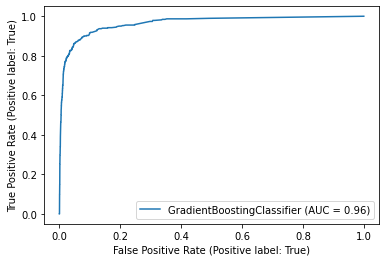

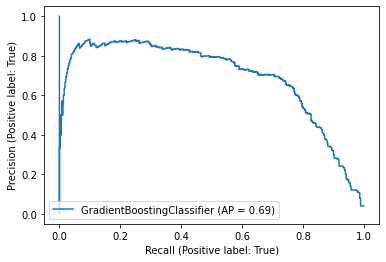

In [167]:
from sklearn.ensemble import GradientBoostingClassifier
xgb_model = GradientBoostingClassifier()
features = twisted_df.drop(['Domain', 'Homograph', 'Registered'], axis=1)
model_eval(features[['MSE', 'SSM','EMBD_EUC']], twisted_df['Registered'] , xgb_model, True);

In [103]:
lev_df, lev_class, probabilities = model_eval(features[['SSM', 'MSE']], twisted_df['Registered'], rf_model)
neg = [i[0] for i in probabilities]
pos = [i[1] for i in probabilities]
print(neg)
print (pos)

precision = 0.6281 ±0.0206
recall    = 0.7365 ±0.0095
f1        = 0.6778 ±0.0142
auc        = 0.8604 ±0.0050
[0.02, 0.03, 0.09, 0.29, 0.01, 0.02, 0.01, 0.0, 0.14, 0.9, 0.0, 0.99, 0.97, 0.86, 0.92, 0.95, 0.99, 0.05, 1.0, 0.85, 0.0, 1.0, 1.0, 0.55, 1.0, 0.98, 1.0, 0.0, 0.34, 0.0, 0.03, 0.17, 0.1, 0.08, 0.18, 0.05, 0.06, 0.35, 0.45, 0.1, 0.1, 0.05, 0.1, 0.54, 0.54, 0.25, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99, 1.0, 1.0, 1.0, 1.0, 0.98, 1.0, 0.98, 1.0, 0.73, 0.97, 0.82, 1.0, 0.93, 0.99, 1.0, 1.0, 0.97, 1.0, 1.0, 1.0, 1.0, 1.0, 0.93, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95, 1.0, 0.98, 1.0, 1.0, 1.0, 1.0, 0.88, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.82, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.93, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 0.91, 0.84, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96, 1.0, 1.0, 1.0, 0.98, 1.0, 1.0, 0.92, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.94, 1.0, 1.0, 0.94, 0.97, 1.0, 1.0, 1.0, 1.0, 0.96, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 0.94, 0.88, 0.97, 1.0, 1.0, 1.0, 1.0, 1

In [104]:
lev_df['Registered'] = lev_class.values
lev_df['Negative Prediction'] = neg
lev_df['Positive Prediction'] = pos
lev_df

,SSM,MSE,Registered,Negative Prediction,Positive Prediction
"(googlea.com, google.com)",0.851078,3562.883354,True,0.02,0.98
"(googlej.com, google.com)",0.849594,3890.821388,True,0.03,0.97
"(googlep.com, google.com)",0.850138,3541.100876,True,0.09,0.91
"(googleg.com, google.com)",0.847150,3639.159492,True,0.29,0.71
"(googlel.com, google.com)",0.852116,3855.488113,True,0.01,0.99
...,...,...,...,...,...
"(insqtagram.com, instagram.com)",0.834099,3613.393341,False,0.12,0.88
"(instagr1am.com, instagram.com)",0.831515,3722.531998,False,0.92,0.08
"(instagra2m.com, instagram.com)",0.832508,3693.410309,False,0.49,0.51
"(instawgram.com, instagram.com)",0.827028,4088.740196,False,0.92,0.08


In [105]:
# Create boolean mask based on the conditions
mask = (lev_df['Registered'] & (lev_df['Positive Prediction'] > lev_df['Negative Prediction']))

# Filter the DataFrame based on the mask
filtered_df = lev_df.loc[mask]

# View the filtered DataFrame
filtered_df

,SSM,MSE,Registered,Negative Prediction,Positive Prediction
"(googlea.com, google.com)",0.851078,3562.883354,True,0.02,0.98
"(googlej.com, google.com)",0.849594,3890.821388,True,0.03,0.97
"(googlep.com, google.com)",0.850138,3541.100876,True,0.09,0.91
"(googleg.com, google.com)",0.847150,3639.159492,True,0.29,0.71
"(googlel.com, google.com)",0.852116,3855.488113,True,0.01,0.99
...,...,...,...,...,...
"(istagram.com, instagram.com)",0.852322,3221.088409,True,0.15,0.85
"(iinstagram.com, instagram.com)",0.821251,4741.810089,True,0.17,0.83
"(instagraam.com, instagram.com)",0.834844,3615.047722,True,0.44,0.56
"(jnstagram.com, instagram.com)",0.908763,1257.719048,True,0.10,0.90


In [108]:
sorted_df = filtered_df.sort_values(by='Positive Prediction', ascending=False)
sorted_df

,SSM,MSE,Registered,Negative Prediction,Positive Prediction
"(tw8itter.com, twitter.com)",0.883237,2551.699104,True,0.00,1.00
"(qoogie.com, google.com)",0.992383,122.182693,True,0.00,1.00
"(microsuft.com, microsoft.com)",0.991773,134.152702,True,0.00,1.00
"(facebooc.com, facebook.com)",0.986877,276.975258,True,0.00,1.00
"(twltter.com, twitter.com)",0.998921,23.120117,True,0.00,1.00
...,...,...,...,...,...
"(baid.com, baidu.com)",0.889837,2497.234947,True,0.47,0.53
"(emazonaws.com, amazonaws.com)",0.992621,114.690033,True,0.47,0.53
"(1nstagrarn.com, instagram.com)",0.826988,4502.406700,True,0.48,0.52
"(insvagram.com, instagram.com)",0.823689,4641.342072,True,0.48,0.52


In [135]:
top_homographs = list(sorted_df.index)

In [147]:
import Levenshtein
edits = []
for pair in list(top_homographs):
    output =  (Levenshtein.editops(pair[0], pair[1]))
    for item in output:
        edits.append((item[0], f'{pair[0][item[1]]} in position {item[1]}', f'{pair[1][item[2]]} in position {item[2]}'))
print (edits)


[('delete', '8 in position 2', 'i in position 2'), ('replace', 'q in position 0', 'g in position 0'), ('replace', 'i in position 4', 'l in position 4'), ('replace', 'u in position 6', 'o in position 6'), ('replace', 'c in position 7', 'k in position 7'), ('replace', 'l in position 2', 'i in position 2'), ('delete', 'j in position 3', 't in position 3'), ('replace', 'n in position 4', 'b in position 4'), ('replace', '0 in position 5', 'o in position 5'), ('replace', '0 in position 6', 'o in position 6'), ('delete', 'p in position 1', 'o in position 1'), ('replace', 'n in position 5', 'b in position 5'), ('delete', 'h in position 4', 'l in position 4'), ('replace', 'q in position 3', 'g in position 3'), ('replace', 'n in position 5', 'o in position 5'), ('replace', 'm in position 2', 'o in position 2'), ('replace', '7 in position 2', 'u in position 2'), ('delete', 'l in position 2', 'u in position 2'), ('replace', 'l in position 2', 'i in position 2'), ('replace', 'l in position 0', 'i i

In [148]:
series_edits = pd.Series(edits)
series_edits.value_counts()[:15]

(replace, e in position 0, a in position 0)    3
(replace, l in position 0, i in position 0)    3
(delete, t in position 7, . in position 7)     2
(delete, k in position 2, i in position 2)     2
(replace, e in position 1, a in position 1)    2
(replace, u in position 3, t in position 3)    2
(replace, t in position 2, u in position 2)    2
(replace, z in position 4, u in position 4)    2
(replace, n in position 9, m in position 8)    2
(delete, r in position 8, m in position 8)     2
(delete, 6 in position 7, . in position 7)     2
(delete, 2 in position 7, . in position 7)     2
(delete, o in position 7, . in position 7)     2
(delete, u in position 2, i in position 2)     2
(replace, 0 in position 6, o in position 6)    2
dtype: int64

In [149]:
import Levenshtein
edits = []
for pair in list(top_homographs):
    output =  (Levenshtein.editops(pair[0], pair[1]))
    for item in output:
        edits.append((item[0], pair[0][item[1]], pair[1][item[2]]))

In [150]:
series_edits = pd.Series(edits)
series_edits.value_counts()[:15]

(replace, e, a)    5
(replace, l, i)    5
(replace, 0, o)    5
(replace, n, m)    4
(delete, a, .)     4
(delete, 6, .)     4
(delete, o, .)     4
(replace, i, a)    4
(delete, r, m)     3
(replace, u, t)    3
(delete, l, .)     3
(replace, t, u)    3
(delete, r, .)     3
(delete, l, o)     2
(delete, g, e)     2
dtype: int64